# Nombre: Brian Sena Simons

# Introducción. 

Primeramente, editaremos y probaremos el código facilitado por el profesor para poder a continuación asegurar que obtenemos resultados similares.
Para ello, tras descargar un nuevo dataset, creamos un conjunto de entrenamiento y uno de test.

El dataset seleccionado, consiste en la clasificación de hasta 6 clases diferentes que corresponden a emociones humanas (Ver en [Kaggle](https://www.kaggle.com/datasets/yousefmohamed20/sentiment-images-classifier/data)). Concretamente, tendremos las clases "Happy", "Sad", "Fear", "Pain", "Anger" y "Disgust". Cada clase está organizada como una carpeta dentro del directorio raíz. Al particionar el dataset, lo haremos de forma balanceada. Por lo tanto, leeremos una carpeta (clase) entera y luego haremos uso de la librería de `sklearn` para realizar la partición del 80%-20%. 

In [1]:
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
# Paths
source_dir = 'emotions_classification'  
destination_dir = 'emotions_classification_split'  
# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)
# Create subdirectories for train and test sets
train_dir = os.path.join(destination_dir, 'train')
test_dir = os.path.join(destination_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
# Loop through the class subdirectories
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    # Only process directories
    if os.path.isdir(class_path):
        # Create class subdirectories in train and test directories
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get all files in the class directory
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        train_files, test_files = train_test_split(files, test_size=0.2, random_state=140421)
        # Move the train files
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_class_dir, file))
        # Move the test files
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_class_dir, file))

print("Dataset split completed and saved to:", destination_dir)

Dataset split completed and saved to: emotions_classification_split


Una vez particionado el dataset, podemos cambiar las variables globales del script facilitado de forma que ahora accede a las carpetas correctas. Además, realizaremos un pequeño cambio sobre el mismo para poder obtener el rendimiento del modelo "SVC" sobre el conjunto de datos nuevo, ya que más adelante cambiaremos bastante el código. Empezaremos tratando las clases "Happy" y "Sad". Para evitar modificar mucho el código facilitado, cargaremos el conjunto de entrenamiento entero (como hace por defecto) y entrenaremos excluyendo las últimas 20 instancias. Sobre estas últimas, calcularemos el acierto de clasificación (accuracy).

# Código original adaptado

In [2]:
import os
import cv2
from sklearn.metrics import accuracy_score
import numpy as np

PATH_POSITIVE_TRAIN = "emotions_classification_split/train/sad/"
PATH_NEGATIVE_TRAIN = "emotions_classification_split/train/happy/"
PATH_POSITIVE_TEST = "emotions_classification_split/test/sad/" 
PATH_NEGATIVE_TEST = "emotions_classification_split/test/happy/"
IMAGE_EXTENSION = ".jpg"


def ejemplo_clasificador_imagenes():
  """
  Prueba de entrenamiento de un clasificador
  """
  # Obtenemos los datos para el entrenamiento del clasificador
  training_data, classes = load_training_data()       
  # Entrenamos el clasificador sobre todas los ejemplos excepto los 20 últimos
  clasificador = train(training_data[:-20], classes[:-20])
  # Hacemos una predicción sobre los 20 restantes
  preds = [int(clasificador.predict(descriptor.reshape(1, -1))[1][0][0]) for descriptor in training_data[-20:]]
  # Enseñamos el resultado obtenido.
  print("Accuracy: ", accuracy_score(preds, classes[-20:]))

def load_training_data():
  """
  Lee las imágenes de entrenamiento (positivas y negativas) y calcula sus
  descriptores para el entrenamiento.

  returns:
  np.array: numpy array con los descriptores de las imágenes leídas
  np.array: numpy array con las etiquetas de las imágenes leídas
  """ 
  training_data = []
  classes = []    

  # Casos positivos
  counter_positive_samples = 0
  for filename in os.listdir(PATH_POSITIVE_TRAIN):
    if filename.endswith(IMAGE_EXTENSION):
      filename = PATH_POSITIVE_TRAIN + filename
      img = cv2.imread(filename)
      img = cv2.resize(img, (128, 128), None)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      hog = cv2.HOGDescriptor()
      descriptor = hog.compute(img)
      training_data.append(descriptor)
      classes.append(1)
      counter_positive_samples += 1

  print("Leidas " + str(counter_positive_samples) + " imágenes de entrenamiento -> positivas")

  # Casos negativos
  counter_negative_samples = 0
  for filename in os.listdir(PATH_NEGATIVE_TRAIN):
    if filename.endswith(IMAGE_EXTENSION):
      filename = PATH_NEGATIVE_TRAIN+filename
      img = cv2.imread(filename)
      img = cv2.resize(img, (128, 128), None)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      hog = cv2.HOGDescriptor()
      descriptor = hog.compute(img)
      training_data.append(descriptor)
      classes.append(0)
      counter_negative_samples += 1
  
  print("Leidas " + str(counter_negative_samples) + " imágenes de entrenamiento -> negativas")

  return np.array(training_data), np.array(classes)


def train(training_data, classes):
  """
      Entrena el clasificador

      Parameters:
      training_data (np.array): datos de entrenamiento
      classes (np.array): clases asociadas a los datos de entrenamiento

      Returns:
      cv2.SVM: un clasificador SVM
  """
  svm = cv2.ml.SVM_create()
  svm.setType(cv2.ml.SVM_C_SVC)
  svm.setKernel(cv2.ml.SVM_LINEAR)
  svm.train(training_data, cv2.ml.ROW_SAMPLE, classes)
  
  return svm


def test(image, clasificador):
  """
  Clasifica la imagen pasada por parámetro
  
  Parameters:
  image (np.array): imagen a clasificar
  clasificador (cv2.SVM): clasificador
  
  Returns:
      int: clase a la que pertenece la imagen (1|0) 
  """
  # HOG de la imagen a testear
  hog = cv2.HOGDescriptor()
  descriptor = hog.compute(image)
  # Clasificación
  # Devuelve una tupla donde el segundo elemento es un array 
  # que contiene las predicciones (en nuestro caso solo una)
  # ej: (0.0, array([[1.]], dtype=float32))
  return int(clasificador.predict(descriptor.reshape(1, -1))[1][0][0])

ejemplo_clasificador_imagenes()

Leidas 178 imágenes de entrenamiento -> positivas
Leidas 183 imágenes de entrenamiento -> negativas
Accuracy:  0.6


Vemos que tenemos ~150 ejemplos de cada clase para entrenamiento y otras 20 para la validación. Con esto, y con el descriptor HOG por defecto obtenemos un acierto del 60%. Este será más o menos el valor esperado de nuestra implementación posterior. Para facilitar el manejo del dataset se hará uso de la librería de "torch" y "torchvision" para crear un conjunto de clase que facilite el manejo de datasets en formato directorio (formato habitual de datasets de imagen). Crearemos una instancia que herede de "ImageFolder" para poder filtrar las clases que queremos seleccionar (el por defecto sería cargar todas las clases del directorio raíz). A posterior, creamos otra instancia que herede de "Datasets" y haga uso de la anterior. La última, será la que instanciemos y a la cual pasemos las transformaciones necesarias antes de cargar las imágenes en memoria (re-escalado, escala de grises...). Para nuestro caso, aplicaremos un re-escalado a 128x128 y un paso a escala de grises para normalizar el tamaño de las imágenes y preparar-las para los descriptores que vamos a utilizar.

# Clase para la carga de datos.

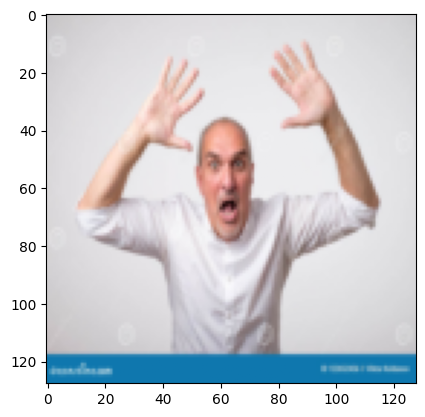

In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.datasets.folder import ImageFolder
import matplotlib.pyplot as plt

# https://github.com/pytorch/vision/issues/4633
class ImageFolderFiltered(ImageFolder):
    def __init__(self, root, transform=None, desired_classes = None, descriptor = None):
      self.desired_classes = desired_classes or []
      super().__init__(root, transform=transform)
      # Precompute descriptors for all images and store them
      self.descriptors = None
      if descriptor is not None:
        self.descriptors = [descriptor(self.__getitem__(i)[0].numpy().astype(np.uint8).transpose(1, 2, 0)) for i in range(len(self.samples))]
 
    
    def find_classes(self, directory):
      if self.desired_classes:
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and any(x in d.name for x in self.desired_classes)]
      else:
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
      classes.sort()  # Sorting classes
      class_to_idx = {cls: i for i, cls in enumerate(classes)}
      return classes, class_to_idx

    def __getitem__(self, index):
      image, label = super().__getitem__(index)
      # Get the precomputed descriptor
      descriptor = -1
      if self.descriptors is not None:
        descriptor = self.descriptors[index]
      return image, label, descriptor 


class EmotionsDataset(Dataset):
    def __init__(self, root_dir, transform=None, desired_classes = None, descriptor = None):
      # Instantiate the super class 
      super(Dataset, self).__init__()
      self.root_dir = root_dir
      self.transform = transform
      # Instantiate our version of find_classes()
      self.dataset = ImageFolderFiltered(root=root_dir, transform=transform, desired_classes=desired_classes, descriptor=descriptor)

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, idx):
      image, label, descriptor = self.dataset[idx]
      return image, label, descriptor

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  # transforms.Grayscale(),
  transforms.ToTensor(),
  ]
)
MyDataset = EmotionsDataset("emotions_classification", transform=transform)
plt.imshow(MyDataset[0][0].numpy().transpose(1, 2, 0))

Con la imagen anterior, vemos que hemos logrado cargar correctamente el conjunto de datos entero. No obstante, no hemos probado filtrar por un conjunto de clases específicos.

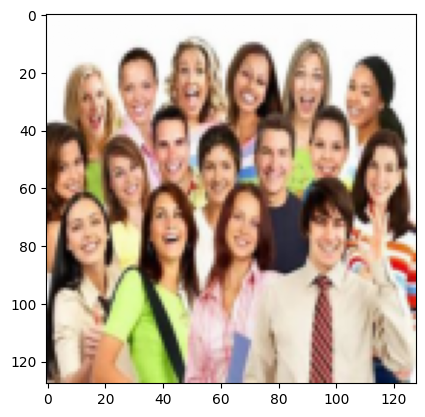

In [7]:
MyHappyDataset = EmotionsDataset("emotions_classification", transform=transform, desired_classes={"happy", "sad"})
plt.imshow(MyHappyDataset[0][0].numpy().transpose(1, 2, 0))

Vemos que si seleccionamos "Happy" y "Sad" la primera imagen que sale es un conjunto de personas felices, diferente a la imagen anterior sin filtrar. Este es el comportamiento esperado y podemos continuar a entrenar un modelo. Sin embargo, "torch" no funciona directamente con "sklearn", la librería que utlizaremos para entrenar un modelo "SVM" para clasificación (de la más usada). Para que funcione, tendremos que cargar nuestro conjunto de imagen en memoria directamente (pierdiendo alguna de las ventajas de la implementación anterior de los Datasets). Para ello, aprovechamos que la implementación anterior permite computar los descriptores en momento de carga (si nuestro dataset es pequeño) y le pasamos el `cv2.HOGDescriptor`. Antes, haremos una función que nos permita dividir nuestros datos en entrenamiento y test.

# División de conjuntos de datos

In [14]:
from torch.utils.data import DataLoader, Subset
from collections import Counter
from sklearn.model_selection import KFold, train_test_split
from PIL import Image

# TODO: clean this un-used function.
def get_dataloaders(
  dataset,
  k_folds=5,
  batch_size=32,
):
  # Set up KFold cross-validation
  kfold = KFold(n_splits=k_folds, shuffle=True)
  # Loop over each fold and yield DataLoaders for training and validation
  for _, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    # Subset the dataset into training and validation
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    # Create DataLoader for training and validation subsets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    yield train_loader, val_loader

# Initialize the dataset
root_dir = 'emotions_classification'  # Replace with the actual path to your image dataset
desired_classes = ["sad", "happy"]

def get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor,
):
  # Load the entire dataset 
  full_dataset = EmotionsDataset(
    root_dir,
    transform=transform,
    desired_classes=desired_classes,
    descriptor=descriptor,
  )
  # Create a list of indexes to later use to subset our dataset 
  indices = list(range(len(full_dataset)))
  train_idx, test_idx = train_test_split(
    indices,
    test_size=.2,
    stratify=full_dataset.dataset.targets,
    random_state=140421, 
  )
  # Create Subsets for training and testing
  train_dataset = Subset(full_dataset, train_idx)
  test_dataset = Subset(full_dataset, test_idx)
  return full_dataset, train_dataset, test_dataset

full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)
print(Counter([full_dataset[i][1] for i in train_dataset.indices]))
print(Counter([full_dataset[i][1] for i in test_dataset.indices]))

Counter({0: 184, 1: 179})
Counter({0: 46, 1: 45})


Vemos que hemos hecho una partición equilibrada entre clases de forma correcta.Ahora podemos sobre el conjunto de entrenamiento (que al llamar a esta función de la misma forma siempre será el mismo) calcular los valores medios y la varianza para poder así normalizar los rangos de valores como se suele hacer en varios datasets. 
También, procedemos a volver a cargalos pero con los descriptores ya computados.

In [15]:
images = []
for image, _, _ in train_dataset:
  images.append(image)

flattened = np.asarray(images).flatten()
mu = np.mean(flattened)
std = np.std(flattened)
print(mu, std)

0.49210197 0.29248017


In [73]:
hog = cv2.HOGDescriptor()
transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  # transforms.Normalize((0.4921,), (0.2924,)),
  ]
)
root_dir = 'emotions_classification'  # Replace with the actual path to your image dataset
desired_classes = ["sad", "happy"]
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=hog.compute
)

# Búsqueda de hiper-parámetros.

Implementamos a continuación la búsqueda de hiper-parámetros con hog. Aprovechamos la desventaja de tener que cargar todos los datos en memoria para entrenar un modelo de estandarización de las características con intención de mejorar los resultados reduciendo las posibles diferencias entre escalas de las variables y las instancias entre sí. Para la búsqueda de hiper-parámetros probaremos con diferentes kernel y niveles de regularización. Mediremos dos métricas, el accuracy y la f1, que nos permite balancear la precisión (porcentaje clasificados como positivos realmente positivos) y el recall (ratios de valores clasificados como positivo correctamente). Para dicha búsqueda, haremos validación cruzada con 5 pliegues. Es decir, partiremos el conjunto de entrenamiento en 80%-20% de 5 formas disjuntas para entrenar y validar sobre diferentes distribuciones.

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  X += [descriptor]
  y += [label]
X = scaler.fit_transform(X)

In [75]:
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

0.6652159145958607 {'C': 0.1, 'kernel': 'linear'}


In [99]:
import polars as pl
# Create a DataFrame with the results
results = pl.DataFrame(gs.cv_results_, strict=False)
results = (
  results.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
results_sum = results.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
results_sum.write_csv("csvs/HOG+SVM.csv")
results_sum

param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.665,0.529
"""linear""",1.0,0.665,0.529
"""linear""",10.0,0.665,0.529
"""poly""",0.1,0.661,0.493
"""poly""",1.0,0.662,0.496
…,…,…,…
"""rbf""",1.0,0.656,0.529
"""rbf""",10.0,0.65,0.523
"""sigmoid""",0.1,0.0,0.507


Obtenemos valores similares a la implementación facilitada, por lo cuál podemos suponer el correcto funcionamiento del código. En este caso, el mejor conjunto de hiper-parámetros parece ser "C=0.1" y el "kernel=linear" con un f1 de 0.66 para el mejor modelo. Ahora probaremos hacerlo con el descriptor LBP.

# LBP-básico

Para la implementación, primeramente probaremos el concepto en ejemplos sencillos. Por ejemplo, para una matriz 3x3 con los números de 0-9 deberíamos obtener para el punto medio (4) una matriz con 5 ceros y 4 unos en la parte final. 

In [9]:
block = np.asarray(range(0,9)).reshape((3,3))
block_size = block.shape
halfpoint = block[block_size[0]//2,block_size[1]//2]
print(block, halfpoint)

[[0 1 2]
 [3 4 5]
 [6 7 8]] 4


In [10]:
np.asarray(block > halfpoint).astype(np.uint8)

array([[0, 0, 0],
       [0, 0, 1],
       [1, 1, 1]], dtype=uint8)

Vemos que efectivamente hemos obtenido dicho resultado, ahora deberíamos obtener lo mismo pero implementando el vecindario por el parámetro radio (R) y puntos (P), para obtener un descriptor similar a la librería con la cual compararemos "skimage". La fórmula parar obtener las cordenadas "x" y "y" de los puntos en un círculo viene dada por `x_c + R * cos(angle)` y `y_c + R * sin(angle)`. 

In [37]:
# we have to choose the neighbours using a circle
block = np.asarray(range(0,9)).reshape((3,3))
block_size = block.shape
halfpoint = block[block_size[0]//2,block_size[1]//2]
n = 8
r = 1
# Therefore, we need to compute the angles
angles = 2 * np.pi / n
# Loop through the neighbors and compare intensity
values = []
for i in range(n):
  # Calculate the coordinates of each neighboring pixel
  angle = i * angles - np.pi / 2
  neighbor_x = round(1 + r * np.cos(angle))
  neighbor_y = round(1 + r * np.sin(angle))
  values += [(neighbor_x, neighbor_y)]
  print(f"Value: {block[neighbor_x, neighbor_y]} at [{neighbor_x, neighbor_y}]")

Value: 3 at [(1, 0)]
Value: 6 at [(2, 0)]
Value: 7 at [(2, 1)]
Value: 8 at [(2, 2)]
Value: 5 at [(1, 2)]
Value: 2 at [(0, 2)]
Value: 1 at [(0, 1)]
Value: 0 at [(0, 0)]


Vemos que obtenemos el vecindario en el orden esperado, según las agujas del reloj. Lo único que quedaría sería comparar dichas posiciones con el valor central y convertir el valor binario en decimal. La idea, es deslizar la ventana de tamaño BxB sobre la imagen de tamaño NxM de SxS1 píxeles calculando el numero en binario con la formula para el vecindario circular. Para más detalles de la primera versión implementada, véase el método `_debug_compute()` que contiene el código previo a la optimización con numpy. 

Para lidiar con las esquinas, haremos uso de un borde sintético con valores iguales a 0 (padding) y así evitar tener que hacer un condicional en cada iteración del bucle. Además, hemos de tener en cuenta que si el paso (stride) es mayor que 1 la imagen final tendrá una dimensión menor que la original. Una vez obtenido la versión de la imagen en rangos de LBP de 0-255, debemos calcular el histograma global (de la imagen entera) o de parches (locales) de tamaño LxL1. De momento, solamente he implementado la posibilidad del global y de parches locales disjuntos (sin solapamiento). 
Para más detalles, y la implementación final con comentarios adicionales, véase el fichero `LBPDescriptor.py`.

In [85]:
class LBPDescriptor():
  def __init__(self, radius = 1, neighbours = 8, stride = (1, 1), block = None):
    self.radius = radius 
    self.neighbours = neighbours
    self.points = self.radius * self.neighbours
    self.windowsize = 2 * self.radius + 1
    self.step = 2 * np.pi / self.neighbours
    self.angles = [n * self.step - np.pi / 2 for n in range(self.neighbours)]
    self.dx = np.round(self.radius * np.cos(self.angles)).astype(np.intp) + self.radius
    self.dy = np.round(self.radius * np.sin(self.angles)).astype(np.intp) + self.radius
    self.stride = stride
    self.block = block

  def _debug_compute(self, img):
    height, width, *_ = img.shape
    lbp = np.zeros_like(img)
    # We have to slide the image to generate the new one
    for x in range(0, width, self.stride[1]):
      for y in range(0, height, self.stride[0]):
        values = []
        for n in range(0, self.neighbours):
          nx = round(x + self.radius * np.cos(self.angles[n]))
          ny = round(y + self.radius * np.sin(self.angles[n]))
          if 0 <= nx < width and 0 <= ny < height:
            values.append(img[nx, ny] >= img[x, y])
          else:
            values.append(np.False_)
        print("".join(["1" if x else "0" for x in values]))
        value = sum([bit << i for i, bit in enumerate(values)])
        lbp[x, y] = value 
    return lbp
  
  def compute(self, img):
    height, width, *_ = img.shape
    padded = cv2.copyMakeBorder(
        img,
        top=self.radius,
        left=self.radius,
        right=self.radius,
        bottom=self.radius,
        borderType=cv2.BORDER_CONSTANT,
        value=0,
    )
    lbp = np.zeros_like(img)
    base_2 = 2 ** np.arange(self.neighbours)
    for x in range(0, height, self.stride[0]):
      for y in range(0, width, self.stride[1]):
        lbp[x, y] = np.dot(
            padded[x + self.dx, y + self.dy] >= img[x, y], base_2
        )

    lbp = lbp[0:height:self.stride[0], 0:width:self.stride[1]]
    lbp_height, lbp_width, *_ = lbp.shape
    descriptors = []
    size_neigh = 2**self.neighbours
    if not self.block:
        block = (lbp_height, lbp_width)
    else:
        block = self.block
    bins = np.arange(size_neigh)
    for x in range(0, lbp_height, block[0]):
      for y in range(0, lbp_width, block[1]):
        hist, _ = np.histogram(
            lbp[x : x + block[0], y : y + block[1]].flatten(),
            bins=bins,
            range=(0, size_neigh),
        )
        # Normalize the histogram
        hist = hist.astype("float32") / hist.sum()
        descriptors.append(hist)
    global_descriptor = np.concatenate(descriptors)
    return lbp, global_descriptor


In [86]:
mylbp = LBPDescriptor(1, 8)
block = np.asarray([
  130, 130, 120, 130, 120, 110, 130, 120, 110
]).reshape((3,3, 1))
print(block.reshape(3,3))
print(LBPDescriptor()._debug_compute(block).reshape(3,3))
res = mylbp.compute(block)
print(res[0].reshape(3,3), res[1].shape)
block = block.reshape(3,3)

[[130 130 120]
 [130 120 110]
 [130 120 110]]
00101000
11000000
11000000
00100110
11100111
11100011
00000010
10000011
10000011
[[ 20   3   3]
 [100 231 199]
 [ 64 193 193]]
[[ 20   3   3]
 [100 231 199]
 [ 64 193 193]] (255,)


Vemos que si aplicamos la clase `LBPDescriptor` sobre el mismo ejemplo anterior obtenemos los resultados esperados. Podemos incluso probar otro ejemplo adicional:

In [40]:
block = np.asarray([
  1, 2, 2, 9, 5, 6, 5, 3, 1
]).reshape((3,3,1))
print(block.reshape(3,3))
print(LBPDescriptor()._debug_compute(block).reshape(3,3))
print(LBPDescriptor().compute(block)[0].reshape(3,3))

[[1 2 2]
 [9 5 6]
 [5 3 1]]
00111000
01111000
11100000
00000000
11001000
00000000
00000110
10000111
10000011
[[ 28  30   7]
 [  0  19   0]
 [ 96 225 193]]
[[ 28  30   7]
 [  0  19   0]
 [ 96 225 193]]


Una vez establecido que el funcionamiento del descriptor es correcto, entrenaremos un modelo SVM con dicho descriptor. 

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  # transforms.Normalize((0.4921,), (0.2924,)),
  ]
)
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)

mylbp = LBPDescriptor()

svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  lbp, descriptor = mylbp.compute(image)
  X += [descriptor]
  y += [label]
X = scaler.fit_transform(X)

In [88]:
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

0.5655535142863817 {'C': 1, 'kernel': 'rbf'}


In [98]:
import polars as pl
lbp_bdf = pl.DataFrame(gs.cv_results_, strict=False)
lbp_bdf = (
  lbp_bdf.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
lbp_bdf_sum = lbp_bdf.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
lbp_bdf_sum.write_csv("csvs/LBPDescriptor.csv")
lbp_bdf_sum

param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.533,0.537
"""linear""",1.0,0.514,0.537
"""linear""",10.0,0.514,0.537
"""poly""",0.1,0.103,0.526
"""poly""",1.0,0.304,0.565
…,…,…,…
"""rbf""",1.0,0.566,0.592
"""rbf""",10.0,0.554,0.556
"""sigmoid""",0.1,0.138,0.504


En este caso, vemos que hemos obtenidos resultados peores que el modelo "HOG+SVM", aunque ambos modelos obtienen resultados relativamente cercanos. En este caso, la combinación "LBP+SVM" obtiene resultados cerca de un 3% peores, con una regulariación "C=10" y un "kernal=rbf" (no-lineal). Podremos comparar estos resultados de nuestro descriptor si utilizamos una librería externa. Por ejemplo, para visualizar el efecto sobre una imagen: 

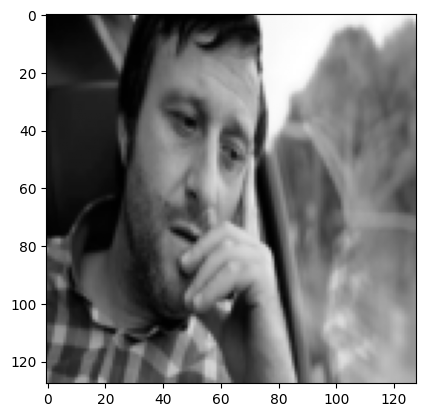

In [190]:
mylbp = LBPDescriptor(1, 8, (1,1))
images = []
for i in train_dataset.indices[:10]:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  lbp, descritor = mylbp.compute(image.copy())
  images.append((lbp, image))
plt.imshow(images[0][1], cmap="gray")

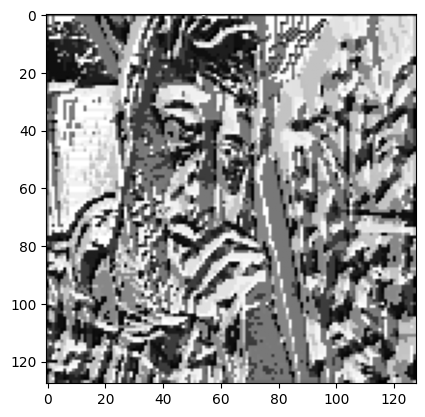

In [191]:
plt.imshow(images[0][0].astype(np.uint8), cmap="gray")

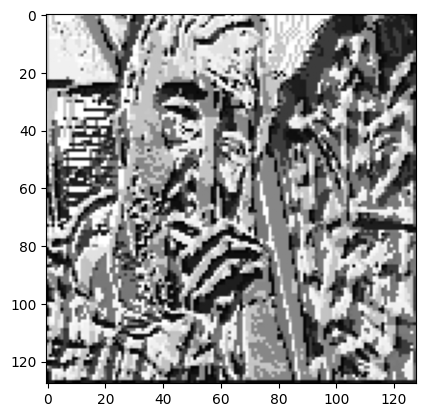

In [192]:
from skimage.feature import local_binary_pattern
sklbp = local_binary_pattern(images[0][1], 8, 1)
plt.imshow(sklbp, cmap="gray")

Vemos que el resultado es algo distinto, probablemente debido a cómo selecciona por debajo los vecinos (igual interpola entre los valores cercano al centro) o igual aplica alguna transformación o paso adicional. Los histogramas son parecidos aunque ligeramos distintos.

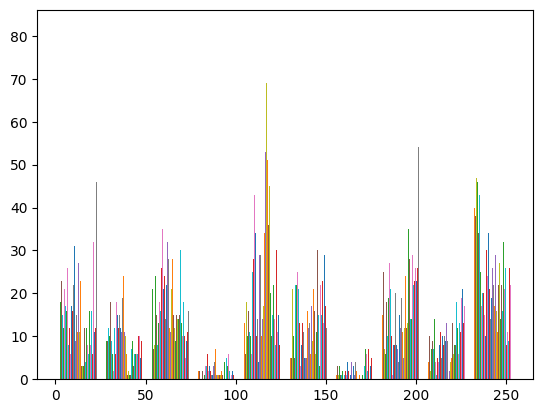

In [193]:
plt.hist(images[0][0])
plt.show()

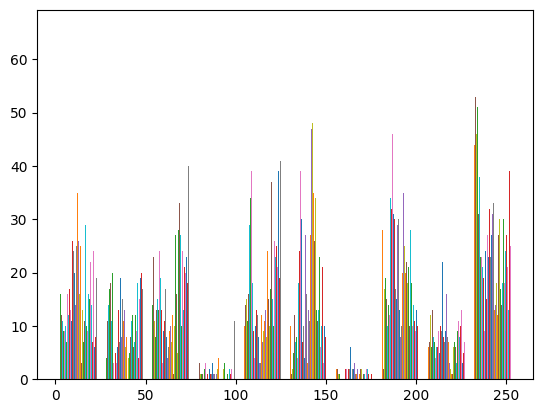

In [194]:
plt.hist(sklbp)
plt.show()

Probamos entrenar un modelo SVM con el LBP de la librería `skimage`.

In [195]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  ]
)
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)

svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  lbp = local_binary_pattern(image, R=1, P=8)
  hist, _ = np.histogram(lbp.flatten(), bins=256, range=(0, 256))
  # Normalize the histogram
  hist = hist.astype('float32') / hist.sum()
  X += [hist]
  y += [label]
X = scaler.fit_transform(X)

In [196]:
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

0.608621743340344 {'C': 10, 'kernel': 'rbf'}


In [197]:
import polars as pl
skilbp = pl.DataFrame(gs.cv_results_, strict=False)
skilbp = (
  skilbp.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
skilbp_sum = skilbp.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
skilbp_sum.write_csv("csvs/skimage.csv")
skilbp_sum

param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.586,0.589
"""linear""",1.0,0.552,0.567
"""linear""",10.0,0.552,0.567
"""poly""",0.1,0.082,0.523
"""poly""",1.0,0.287,0.565
…,…,…,…
"""rbf""",1.0,0.579,0.6
"""rbf""",10.0,0.609,0.6
"""sigmoid""",0.1,0.179,0.507


Vemos que obtenemos un rendimiento más cercano al "HOG+SVM" con un 60% frente al 56% obtenido con nuestro descriptor. Sea cuál sea la transformación o paso adicional que realiza `skimage`, sería interesante implementarlo en nuestro descriptor.

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  transforms.Normalize((0.4921,), (0.2924,)),
  ]
)
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)

mylbp = LBPDescriptor()
svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  lbp, descriptor = mylbp.compute(image)
  X += [descriptor]
  y += [label]
X = scaler.fit_transform(X)

In [115]:
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

0.6348051724044996 {'C': 10, 'kernel': 'rbf'}


In [116]:
import polars as pl
nlbp_bdf = pl.DataFrame(gs.cv_results_, strict=False)
nlbp_bdf = (
  nlbp_bdf.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
nlbp_bdf_sum = nlbp_bdf.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
nlbp_bdf_sum.write_csv("csvs/NormLBPDescriptor.csv")
nlbp_bdf_sum

param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.555,0.573
"""linear""",1.0,0.555,0.562
"""linear""",10.0,0.555,0.562
"""poly""",0.1,0.257,0.562
"""poly""",1.0,0.376,0.592
…,…,…,…
"""rbf""",1.0,0.623,0.661
"""rbf""",10.0,0.635,0.655
"""sigmoid""",0.1,0.567,0.567


Vemos que si normalizamos los rangos de valores de nuestro conjunto de datos mejoramos en casi un 6% nuestro modelo de clasificación con nuestra clase LBPDescriptor, acercándonos a los resultados obtenidos con la implementación de skimage.

# LBPUniforme

Para el caso del descriptor uniforme podemos utilizar la misma clase definida anteriormente. No obstante, necesitamos implementar un paso adicional de comprobar el número de transiciones de 0 a 1 y de 1 a 0 en nuestro número binario obtenido.

In [25]:
arr = np.array([np.False_, np.False_, np.True_, np.False_, np.True_, np.True_])
transitions = np.sum(arr[:-1] != arr[1:])
transitions

np.int64(3)

Vemos que podemos contar-los de esta forma. Ahora probamos generar una tabla de "traducción" de número decimal a etiqueta del descriptor uniforme. Primero, partiendo de la implementación anterior en la que un valor binario lo convertíamos a decimal, podemos crear una lista con las etiquetas. 

In [26]:
lookup_table = np.full((2**8), 58)
cont = 0
for i in range(2**8):
  bits = np.asarray(list(f'{i:08b}')).astype(np.uint8)
  transitions = np.sum(bits[:-1] != bits[1:])
  if transitions == 0 or transitions <= 2:
    lookup_table[i] = cont 
    cont += 1
lookup_table

array([ 0,  1,  2,  3,  4, 58,  5,  6,  7, 58, 58, 58,  8, 58,  9, 10, 11,
       58, 58, 58, 58, 58, 58, 58, 12, 58, 58, 58, 13, 58, 14, 15, 16, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 17, 58, 58,
       58, 58, 58, 58, 58, 18, 58, 58, 58, 19, 58, 20, 21, 22, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 23, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 24, 58, 58, 58, 58, 58, 58,
       58, 25, 58, 58, 58, 26, 58, 27, 28, 29, 30, 58, 31, 58, 58, 58, 32,
       58, 58, 58, 58, 58, 58, 58, 33, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 34, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 35, 36, 37, 58, 38, 58, 58, 58, 39, 58, 58, 58, 58,
       58, 58, 58, 40, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 41, 42, 43

Si la comparamos con la tabla de la diapositiva

In [27]:
# From notes
lookup = [
      0, 1, 2, 3, 4, 58, 5, 6, 7, 58, 58, 58, 8, 58, 9, 10,
11, 58, 58, 58, 58, 58, 58, 58, 12, 58, 58, 58, 13, 58, 14, 15,
16, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
17, 58, 58, 58, 58, 58, 58, 58, 18, 58, 58, 58, 19, 58, 20, 21,
22, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
23, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
24, 58, 58, 58, 58, 58, 58, 58, 25, 58, 58, 58, 26, 58, 27, 28,
29, 30, 58, 31, 58, 58, 58, 32, 58, 58, 58, 58, 58, 58, 58, 33,
58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 34,
58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 35,
36, 37, 58, 38, 58, 58, 58, 39, 58, 58, 58, 58, 58, 58, 58, 40,
58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 41,
42, 43, 58, 44, 58, 58, 58, 45, 58, 58, 58, 58, 58, 58, 58, 46,
47, 48, 58, 49, 58, 58, 58, 50, 51, 52, 58, 53, 54, 55, 56, 57
    ]

all(lookup_table == lookup)

True

Vemos que todos los valores coinciden, por lo cual podemos aplicar dicha tabla a nuestro descriptor anterior para obtener la versión "uniforme". 

In [145]:
class LBPUniform():
  def __init__(self, radius = 1, neighbours = 8, stride = (1, 1), block = None):
    self.radius = radius 
    self.neighbours = neighbours
    self.points = self.radius * self.neighbours
    self.windowsize = 2 * self.radius + 1
    self.step = 2 * np.pi / self.neighbours
    self.angles = [n * self.step - np.pi / 2 for n in range(self.neighbours)]
    self.dx = np.round(self.radius * np.cos(self.angles)).astype(np.intp) + self.radius
    self.dy = np.round(self.radius * np.sin(self.angles)).astype(np.intp) + self.radius
    self.stride = stride
    self.block = block
    self.lookup = self.generate_lookup_table()
  
  def generate_lookup_table(self):
    # TODO: How can we make the number 58 scale if we have more than 8 neighbours?
    lookup_table = np.full((2**self.neighbours), 58)
    cont = 0
    for i in range(2**self.neighbours):
      bits = np.asarray(list(f'{i:0{self.neighbours}b}')).astype(np.uint8)
      transitions = np.sum(bits[:-1] != bits[1:])
      if transitions == 0 or transitions <= 2:
        lookup_table[i] = cont 
        cont += 1
    return lookup_table

  def compute(self, img):
    height, width, *_ = img.shape
    padded = cv2.copyMakeBorder(
        img,
        top=self.radius,
        left=self.radius,
        right=self.radius,
        bottom=self.radius,
        borderType=cv2.BORDER_CONSTANT,
        value=0,
    )
    lbp = np.zeros_like(img)
    # TODO: We can avoid the computation of the decimal number if we create a hash lookup table instead of a list.
    base_2 = 2 ** np.arange(self.neighbours)
    for x in range(0, height, self.stride[0]):
      for y in range(0, width, self.stride[1]):
          lbp[x, y] = self.lookup[np.dot(
              padded[x + self.dx, y + self.dy] >= img[x, y], base_2
          )]
    lbp = lbp[0:height:self.stride[0], 0:width:self.stride[1]]
    lbp_height, lbp_width, *_ = lbp.shape
    descriptors = []
    if not self.block:
        block = (lbp_height, lbp_width)
    else:
        block = self.block
    # TODO: How does the number of bins scale with the size of neighbours?
    bins = np.arange(59)
    size_neigh = 59
    for x in range(0, lbp_height, block[0]):
      for y in range(0, lbp_width, block[1]):
        hist, _ = np.histogram(
            lbp[x : x + block[0], y : y + block[1]].flatten(),
            bins=bins,
            range=(0, size_neigh),
        )
        # Normalize the histogram
        hist = hist.astype("float32") / hist.sum()
        descriptors.append(hist)
    global_descriptor = np.concatenate(descriptors)
    return lbp, global_descriptor

In [29]:
mylbp = LBPUniform(1, 8)
block = np.asarray([
  130, 130, 120, 130, 120, 110, 130, 120, 110
]).reshape((3,3, 1))
print(block.reshape(3,3))
pres = LBPDescriptor()._debug_compute(block).reshape(3,3)
print(np.asarray([lookup[x] for x in pres.flatten()]).reshape(3,3))
res = mylbp.compute(block)
print(res[0].reshape(3,3), res[1].shape)
block = block.reshape(3,3)

[[130 130 120]
 [130 120 110]
 [130 120 110]]
00101000
11000000
11000000
00100110
11100111
11100011
00000010
10000011
10000011
[[58  3  3]
 [58 45 39]
 [22 37 37]]
[[58  3  3]
 [58 45 39]
 [22 37 37]] (58,)


Vemos que el resultado de utilizar la tabla "auto-generada" con la presente en la documentación de la práctica obtenemos el mismo resultado. Dicho esto, procedemos a hacer la búsqueda de hiper-parámetros para este descriptor uniforme.

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  ]
)
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)

mylbp = LBPUniform()

svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  X += [mylbp.compute(image)[1]]
  y += [label]
X = scaler.fit_transform(X)

In [150]:
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

0.6070895479346183 {'C': 10, 'kernel': 'rbf'}


In [152]:
import polars as pl
lbpu_bdf = pl.DataFrame(gs.cv_results_, strict=False)
lbpu_bdf = ( 
  lbpu_bdf.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
lbpu_bdf_sum = lbpu_bdf.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
lbpu_bdf_sum.write_csv("csvs/LBPUniform.csv")
lbpu_bdf_sum

param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.561,0.601
"""linear""",1.0,0.566,0.595
"""linear""",10.0,0.567,0.593
"""poly""",0.1,0.278,0.556
"""poly""",1.0,0.438,0.584
…,…,…,…
"""rbf""",1.0,0.587,0.617
"""rbf""",10.0,0.607,0.612
"""sigmoid""",0.1,0.49,0.559


Vemos que con esta nueva implementación del descriptor uniforme hemos logrado el mismo resultado que la librería de `skimage` para el "kernel=rbf" (no-lineal) y "C=10". Aún así, obtenemos resultados inferiores a la implementación de "HOG+SVM" por un ~5%. En este caso, la información que aporta el gradiente de las imágenes parece ser más característico para distinguir las clases. 

[[13 15 13 ... 58 11  0]
 [26 57 26 ... 48 47 36]
 [26 57 26 ... 43 48 36]
 ...
 [22 38 34 ... 10 10  6]
 [22 38 57 ... 33 15  6]
 [22 37 58 ... 30 30 37]]


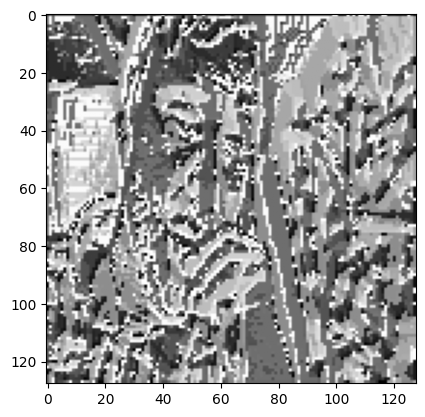

In [201]:
mylbp = LBPUniform(1, 8, (1,1))
lbp = mylbp.compute(images[0][1])[0]
print(lbp)
plt.imshow(lbp, cmap="gray")

[[3. 5. 3. ... 9. 1. 0.]
 [5. 8. 5. ... 5. 4. 2.]
 [5. 8. 5. ... 4. 5. 2.]
 ...
 [1. 4. 6. ... 4. 4. 3.]
 [1. 4. 8. ... 5. 5. 3.]
 [1. 3. 9. ... 2. 2. 3.]]


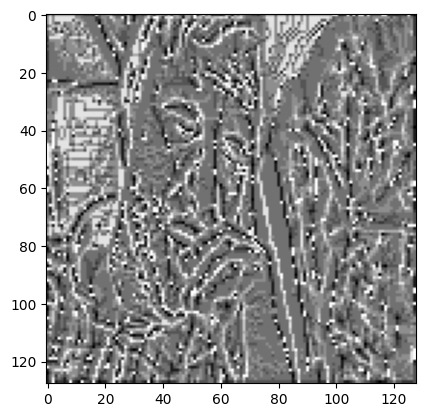

In [206]:
from skimage.feature import local_binary_pattern
sklbp = local_binary_pattern(images[0][1], P=8, R=1, method="uniform")
print(sklbp)
plt.imshow(sklbp, cmap="gray")

In [154]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  transforms.Normalize((0.4921,), (0.2924,)),
  ]
)
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)

mylbp = LBPUniform()

svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  X += [mylbp.compute(image)[1]]
  y += [label]
X = scaler.fit_transform(X)
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)
import polars as pl
nlbpu_bdf = pl.DataFrame(gs.cv_results_, strict=False)
nlbpu_bdf = (
  nlbpu_bdf.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
nlbpu_bdf_sum = nlbpu_bdf.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
nlbpu_bdf_sum.write_csv("csvs/NormLBPUniform.csv")
nlbpu_bdf_sum

0.6326166378169228 {'C': 1, 'kernel': 'rbf'}


param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.581,0.612
"""linear""",1.0,0.588,0.609
"""linear""",10.0,0.55,0.568
"""poly""",0.1,0.217,0.545
"""poly""",1.0,0.345,0.556
…,…,…,…
"""rbf""",1.0,0.633,0.65
"""rbf""",10.0,0.63,0.636
"""sigmoid""",0.1,0.45,0.554


In [204]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose(
  [
  # By default, I'll set the size to 128x128 for now.
  transforms.Resize((128, 128)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  ]
)
full_dataset, train_dataset, test_dataset = get_train_test_dataset(
  root_dir, transform, desired_classes, descriptor=None
)

svm = SVC()
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels (Non linear)
}
gs = GridSearchCV(
  svm,
  params,
  refit="f1",
  cv=5,
  scoring=['accuracy', 'f1'],
  # return_train_score=True,
)
X, y = [], []
for i in train_dataset.indices:
  image, label, descriptor = full_dataset[i]
  image = np.asarray(image).transpose(1,2,0)
  image = (image.reshape(image.shape[:-1]) * 255).astype(np.uint8)
  lbp = local_binary_pattern(image, R=1, P=8, method='uniform')
  hist, _ = np.histogram(lbp.flatten(), bins=58, range=(0, 58))
  # Normalize the histogram
  hist = hist.astype('float32') / hist.sum()
  X += [hist]
  y += [label]
X = scaler.fit_transform(X)

In [205]:
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)
import polars as pl
skiu_bdf = pl.DataFrame(gs.cv_results_, strict=False)
skiu_bdf = (
  skiu_bdf.with_columns(pl.col("mean_test_f1").round(3), pl.col("mean_test_accuracy").round(3))
)
skiu_bdf_sum = skiu_bdf.sort(["param_kernel", "param_C"])["param_kernel", "param_C", "mean_test_f1", "mean_test_accuracy"]
skiu_bdf_sum.write_csv("csvs/SkimageUniform.csv")
skiu_bdf_sum

0.6472108552214186 {'C': 10, 'kernel': 'rbf'}


param_kernel,param_C,mean_test_f1,mean_test_accuracy
str,f64,f64,f64
"""linear""",0.1,0.614,0.623
"""linear""",1.0,0.622,0.625
"""linear""",10.0,0.622,0.625
"""poly""",0.1,0.333,0.587
"""poly""",1.0,0.462,0.611
…,…,…,…
"""rbf""",1.0,0.628,0.625
"""rbf""",10.0,0.647,0.655
"""sigmoid""",0.1,0.485,0.554


## Detección de Objeto

La idea es, tras entrenar un modelo, obtener parches de la imagen sobre los cuales calcularemos los descriptores e intentaremos clasificar dicha muestra. Si, pasado un umbral de certeza logramos obtener una clasificación de alguna de las clases, almacenamos dicho parche en una lista. Hacemos repetidas veces este procedimiento sobre múltiples escalas (variando el tamaño de la imagen original sobre la cual trabajamos). Para finalizar, refinamos las cajas obtenidas con la información multi-escala. Para finalizar, dibujamos los resultados obtenidos en pantalla.

# Ejemplo de ejecución sobre MNIST con 4 Clases

Para validar el código anterior, realizaremos la búsqueda de hiper-parámetros sobre el conjunto de MNIST para las clases "9", "2", "6", y "background" siguiendo los criterios de elección de números descrito en el documento de práctica. Así, también, comprobamos que podemos realizar la clasificación para más de 2 clases fácilmente con tan solo incluir una clase más en nuestro filtro de `desired_clases`. 

In [218]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Load the hog descriptor with the correct configuration for 28x28 images
hog = cv2.HOGDescriptor(
  _winSize=(28,28),
  _cellSize=(4,4),
  _blockSize=(8,8),
  _blockStride=(2,2),
  _nbins=9,
)
# Filter the desired clases 
mnist_desired_classes = ["two", "six", "nine", "background"] 

# TODO: Better way to subsample train_dataset to use less than 50000 instances for training.
# NOTE: using a 0.2% of the training (validation_set) as training is sketchy
MNIST_transform = transforms.Compose([
  transforms.ToTensor(), 
  transforms.Grayscale(), # Just in case I guess
  transforms.Normalize((0.1307,), (0.3081,)),
]) 
# Load the entire dataset 
train_dataset = EmotionsDataset(
  "mnist_data_with_background/mnist_data_with_background/train",
  transform=MNIST_transform,
  desired_classes=mnist_desired_classes, 
  descriptor=None,
)
indices = list(range(len(train_dataset)))
train_idx, reduced_train_idx = train_test_split(
  indices,
  test_size=.05, # Approx 1500
  stratify=train_dataset.dataset.targets,
  random_state=140421, 
)
print(len(reduced_train_idx))
# Create Subsets for training and testing
reduced_train_dataset = Subset(train_dataset, reduced_train_idx)
svm = SVC(probability=True)
scaler = StandardScaler()
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    # 'decision_function_shape': ["ovo", "ovr"]
}
gs = GridSearchCV(
  svm,
  params,
  refit="f1_macro",
  cv=5,
  scoring=['accuracy', 'f1_macro'],
  # return_train_score=True,
)
X, y = [], []
for i in reduced_train_dataset.indices:
  image, label, descriptor = train_dataset[i]
  X += [hog.compute(image.numpy().astype(np.uint8).transpose(1, 2, 0))]
  y += [label]
X = scaler.fit_transform(X)

1418


In [219]:
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)
best_svm = gs.best_estimator_

0.9966377057286149 {'C': 1, 'kernel': 'sigmoid'}


Vemos que para 4 clases, obtenemos resultados realmente interesantes con `f1_macro` de casi 99.9% para la combinación de hiper-parámetros obtenida.

(1600, 1091)


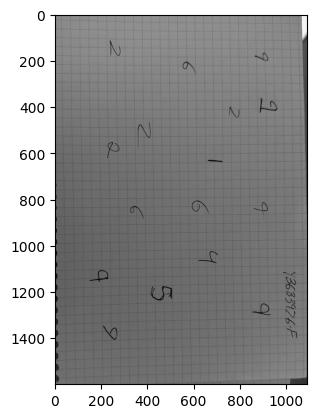

In [220]:
image = cv2.imread("HandWritten.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(image, cmap="gray")

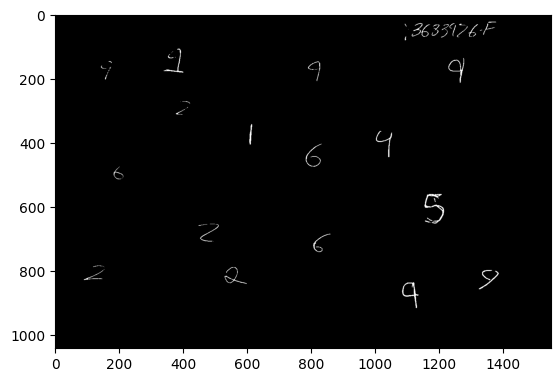

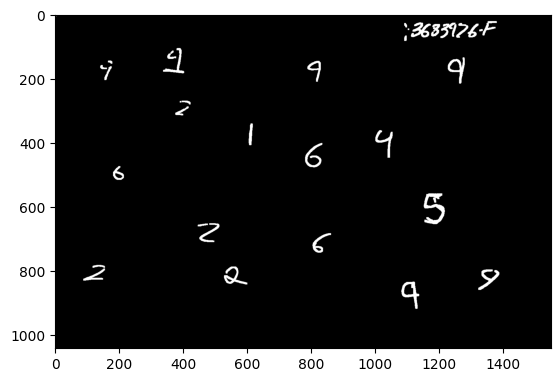

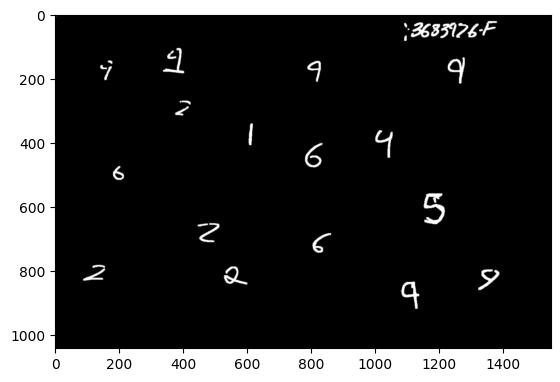

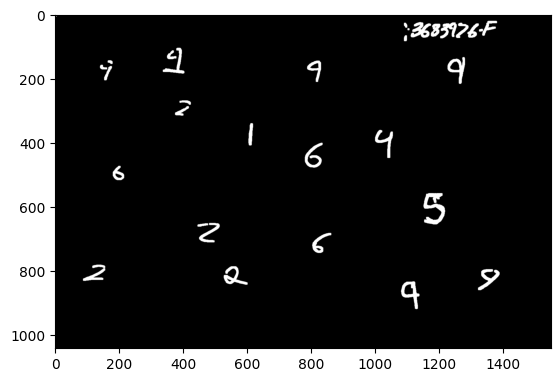

In [221]:
# Inverse binary threshold
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated = rotated[25:-25, 25:-25]
_, binary_image = cv2.threshold(rotated, 50, 255, cv2.THRESH_BINARY_INV)  
plt.imshow(binary_image, cmap="gray")
plt.show()
# Apply morphological dilation to enlarge the lines
kernel = np.ones((5, 5), np.uint8)  # Square kernel of size 5x5
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
plt.imshow(dilated_image, cmap="gray")
plt.show()
# Smooth the edges after dilation if needed
smoothed_image = cv2.GaussianBlur(dilated_image, (3, 3), 0)
plt.imshow(smoothed_image, cmap="gray")
plt.show()
def normalize_image(img):
  # Normalize the image: (image - mean) / std
  mean = 0.1307
  std = 0.3081
  normalized_image = (img - mean) / std

  # Optionally, clip values to the range [0, 255] for display or further processing
  return np.clip(normalized_image, 0, 255).astype(np.uint8)
normalized = normalize_image(smoothed_image)
# normalized = normalize_image(rotated)
plt.imshow(normalized, cmap="gray")
plt.show()

In [222]:
print(train_dataset.dataset.classes)
print(train_dataset.dataset.class_to_idx["background"])

['background', 'nine', 'six', 'two']
0


In [223]:
copy = normalized.copy()
block_size = (28, 28)
block_stride = (9, 9)
bboxes = []
thresh = 0.80
target = copy
sizes = [256, 128, 64]
og_h, og_w = (sizes[0], sizes[0])
for i, size in enumerate(sizes):
  target = cv2.resize(copy, (size, size), interpolation=cv2.INTER_LANCZOS4)
  height, width, *_ = target.shape
  scx, scy = og_h / height, og_w / width
  for x in range(0, height, block_stride[0]):
    for y in range(0, width, block_stride[1]):
      selected = target[x:x+block_size[0], y:y+block_size[1]]
      dh, dw, *_ = selected.shape
      dh = (block_size[0] - dh) 
      dw = (block_size[1] - dw) 
      selected = cv2.copyMakeBorder(selected, top = 0, left = 0, bottom = dh, right = dw, borderType=cv2.BORDER_CONSTANT, value = 0)
      selected_descriptor = hog.compute(selected)
      selected_descriptor = scaler.transform(selected_descriptor.reshape(1, -1))
      log_pb = best_svm.predict_proba(selected_descriptor.reshape(1, -1))[0]
      maxi = np.argmax(log_pb) 
      if log_pb[maxi] >= thresh and maxi != train_dataset.dataset.class_to_idx["background"]:
        sx, sy = int(x*scx), int(y*scy)
        bboxes += [(maxi,log_pb[maxi], (sx, sy, int((x+block_size[0])*scx), int((y+block_size[1])*scy)), (height, width))]
bboxes = sorted(bboxes, key = lambda x: x[1], reverse=True)
print(bboxes)

[(np.int64(3), np.float64(0.9929732067257876), (0, 189, 28, 217), (256, 256)), (np.int64(3), np.float64(0.9829184049468246), (0, 180, 28, 208), (256, 256)), (np.int64(1), np.float64(0.9713567221930938), (18, 45, 46, 73), (256, 256)), (np.int64(2), np.float64(0.9691844377523855), (99, 117, 127, 145), (256, 256)), (np.int64(3), np.float64(0.9338716561677856), (0, 198, 28, 226), (256, 256)), (np.int64(3), np.float64(0.9242190561715803), (27, 45, 55, 73), (256, 256)), (np.int64(2), np.float64(0.9225307998798293), (189, 81, 217, 109), (256, 256)), (np.int64(2), np.float64(0.9054875329717047), (108, 18, 136, 46), (256, 256)), (np.int64(1), np.float64(0.9011196567652794), (180, 72, 208, 100), (256, 256)), (np.int64(3), np.float64(0.8726156271926246), (144, 180, 172, 208), (256, 256)), (np.int64(3), np.float64(0.8719545947324842), (36, 54, 64, 82), (256, 256)), (np.int64(3), np.float64(0.8506027227087123), (0, 207, 28, 235), (256, 256)), (np.int64(2), np.float64(0.8269561263315538), (135, 180,

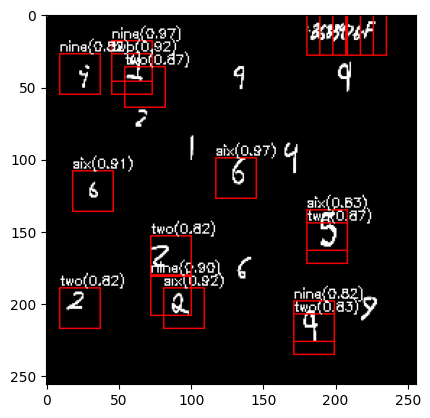

In [224]:
copy = cv2.resize(normalized, (sizes[0], sizes[0]), interpolation=cv2.INTER_LANCZOS4)
copy = cv2.cvtColor(copy, cv2.COLOR_GRAY2RGB)
original_height, original_width, *_ = copy.shape
for bbox in bboxes:
  # Extract data from the list
  class_id, confidence, (x, y, fx, fy), image_size = bbox
  # Draw the bounding box (using the class label and confidence)
  color = (255, 0, 0) # Green color for the bounding box
  thickness = 1  # Thickness of the bounding box lines
  cv2.rectangle(
    copy,
    (y, x), 
    (fy, fx),
    color,
    thickness
  )
  # Prepare the text (class label and confidence)
  label = f"{train_dataset.dataset.classes[class_id]}({confidence:.2f})"
  # Set text position
  text_position = (y, x - 2)  # Just above the bbox
  # Set font, size, and color for the text
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.3
  font_color = (255, 255, 255)  # White text
  font_thickness = 1
  # Add the text to the image
  cv2.putText(copy, label, text_position, font, font_scale, font_color, font_thickness)
  # Display the image (if you want to check the result)
  plt.imshow(copy, cmap="gray")
plt.show()

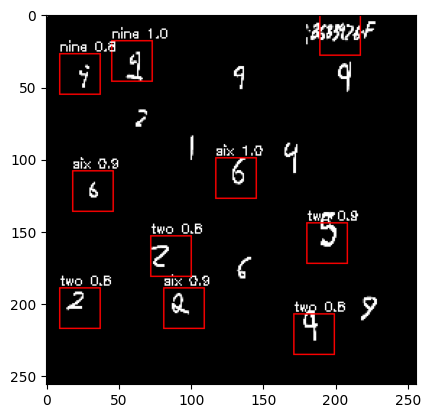

In [225]:
# https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def compute_iou(box1, box2):
    # Coordinates for box1: (x1, y1, x2, y2)
    x1, y1 = box1[0]
    fx1, fy1 = box1[1]
    x2, y2 = box2[0]
    fx2, fy2 = box2[1]
    
    # Coordinates for intersection
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(fx1, fx2)
    inter_y2 = min(fy1, fy2)
    
    # If there is no intersection
    if inter_x1 >= inter_x2 or inter_y1 >= inter_y2:
        return 0.0
    
    # Calculate the area of intersection
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    
    # Calculate the area of both bounding boxes
    area1 = (y1 - fy1) * (x1 - fx1)
    area2 = (y2 - fy2) * (x2 - fx2)
    
    # Calculate IoU
    union_area = area1 + area2 - inter_area
    iou = inter_area / union_area
    return iou

# Refine bounding boxes based on IoU and confidence
def refine_bounding_boxes(bboxes, iou_threshold=0.5):
  # Sort bounding boxes by confidence, in descending order
  bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
  refined_boxes = []
  for bbox in bboxes:
    _, _, (x, y, fx, fy), (w, h) = bbox
    # Keep the current bbox if it does not overlap with any already refined bbox
    add_box = True
    for refined_bbox in refined_boxes:
      _, _, (rx, ry, rfx, rfy), (rw, rh) = refined_bbox
      iou = compute_iou(((x, y), (fx, fy)), ((rx, ry), (rfx, rfy)))
      if iou > iou_threshold:
        # If overlap is high, only keep the one with greater confidence
        add_box = False
        break
      
    if add_box:
      refined_boxes.append(bbox)
  
  return refined_boxes

copy = cv2.resize(normalized, (sizes[0], sizes[0]), interpolation=cv2.INTER_LANCZOS4)
copy = cv2.cvtColor(copy, cv2.COLOR_GRAY2RGB)
original_height, original_width, *_ = normalized.shape
pre_boxes = refine_bounding_boxes(bboxes, iou_threshold=0.1)
for bbox in pre_boxes:
  # Extract data from the list
  class_id, confidence, (x, y, fx, fy), image_size = bbox
  # Draw the bounding box (using the class label and confidence)
  color = (255, 0, 0) # Green color for the bounding box
  thickness = 1  # Thickness of the bounding box lines
  cv2.rectangle(
    copy,
    (y, x), 
    (fy, fx),
    color,
    thickness
  )
  # Prepare the text (class label and confidence)
  label = f"{train_dataset.dataset.classes[class_id]} {confidence:.1f}"
  # Set text position
  text_position = (y, x - 2) 
  # Set font, size, and color for the text
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.3
  font_color = (255, 255, 255)  
  font_thickness = 1
  # Add the text to the image
  cv2.putText(copy, label, text_position, font, font_scale, font_color, font_thickness)
  # Display the image (if you want to check the result)
  plt.imshow(copy, cmap="gray")
plt.show()

Vemos que hemos logrado detectar un par de clases en la parte derecha del ejemplo. Incluso, observamos que hemos detectado imágenes rotadas (el número 6).